# Jetson YOLO Intro
This project is designed to be a starting point for running YOLO (You Only Look Once) object detection models on NVIDIA Jetson devices.
It provides guidance on getting started with YOLO models, including a small showcase of each task YOLO can perform.

## Prepare Environment

### Install System Packages
```bash
sudo apt update
sudo apt install python3-venv python3-pip python3-opencv
```

### Python Virtual Environment
Create a Python virtual environment with access to system packages:
```bash
python3 -m venv <venv-path> --system-site-packages
source <venv-path>/bin/activate
```

### Install Python Packages
```bash
pip3 install torch torchvision --index-url=https://pypi.jetson-ai-lab.io/jp6/cu126
pip3 install -r requirements.txt
pip3 install ultralytics --no-deps # Install ultralytics without dependencies, can't be done through requirements.txt
```

### Note on camera usage
Ultralytics will install the Python package of OpenCV and Numpy in version 2.X. However, this will break the camera usage on Jetson devices. Therefore, we need to manually install the system package of OPenCV and downgrade Numpy.

## Running snippets
When running snippets, press the small recangle icon on the top left of the cell to stop execution.

In [1]:
# Import requirements
import cv2
from IPython.display import display, Image, clear_output
import time
from ultralytics import YOLO

GStreamer pipeline to access CSI camera correctly.

In [4]:
# Prepare gsteamer pipeline for Jetson camera
def gstreamer_pipeline(
    capture_width=640,
    capture_height=480,
    framerate=30,
    flip_method=2,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (capture_width, capture_height, framerate, flip_method, capture_width, capture_height)
    )

Test code to validate camera functionallity. If it does, a live feed of the camera should appear.

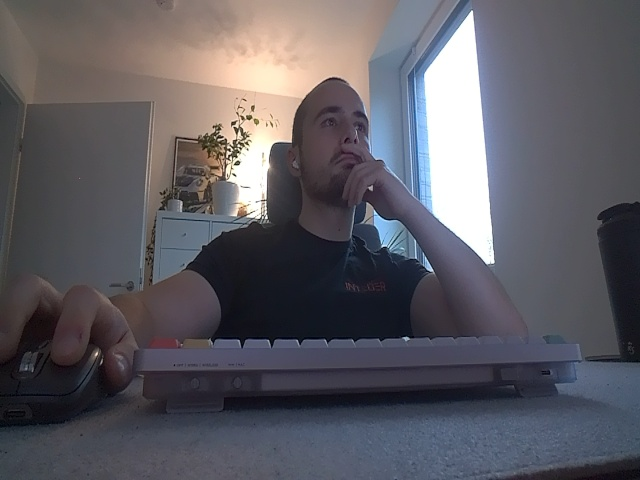

Stopped
GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success
Camera released


In [42]:
# Test if camera stream is working
cap = cv2.VideoCapture(gstreamer_pipeline(), cv2.CAP_GSTREAMER)

if not cap.isOpened():
    print("ERROR: Could not open camera")
else:
    print("Camera opened! Streaming... (stop with the stop button)")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to read frame")
                break
            
            _, jpeg = cv2.imencode('.jpg', frame)
            clear_output(wait=True)
            display(Image(data=jpeg.tobytes()))
            
            time.sleep(0.05)
            
    except KeyboardInterrupt:
        print("Stopped")
    finally:
        cap.release()
        print("Camera released")

Helper function to streamline model loading and inference. 
Starts the video capture, processes each frame through the YOLO model, and displays the results in real-time with FPS information.

In [2]:
def run_model(model):
    cap = cv2.VideoCapture(gstreamer_pipeline(), cv2.CAP_GSTREAMER)

    # Prepare for FPS calculation
    freq = cv2.getTickFrequency()

    try:
        while True:
            # Get start tick for FPS calculation
            t1 = cv2.getTickCount()

            # Read frame
            ret, frame = cap.read()
            if not ret:
                break
            
            # Run detection
            results = model(frame, verbose=False)
            annotated = results[0].plot()
            
            # Add FPS to frame
            t2 = cv2.getTickCount()
            time1 = (t2-t1)/freq
            frame_rate_calc = 1/time1
            annotated_with_fps = cv2.putText(annotated, # Image to draw text on
                                            f'FPS: {frame_rate_calc:.2f}', # Text to display
                                            (5, 470), # Position (bottom-left corner)
                                            cv2.FONT_HERSHEY_SIMPLEX, # Font
                                            0.5, # Font scale
                                            (255, 0, 0), # Font color
                                            1, # Font weight (thickness)
                                            cv2.LINE_AA) # Line type

            # Convert to JPEG bytes for display
            _, jpeg = cv2.imencode('.jpg', annotated_with_fps)
            
            # Display in notebook
            clear_output(wait=True)

            display(Image(data=jpeg.tobytes()))
            
    except KeyboardInterrupt:
        pass
    finally:
        cap.release()

## YOLO Detection

Detection is the primary task of YOLO models. Objects in the video stream are detected and highlighted with bounding boxes.
Each bounding box includes the class label and confidence score.

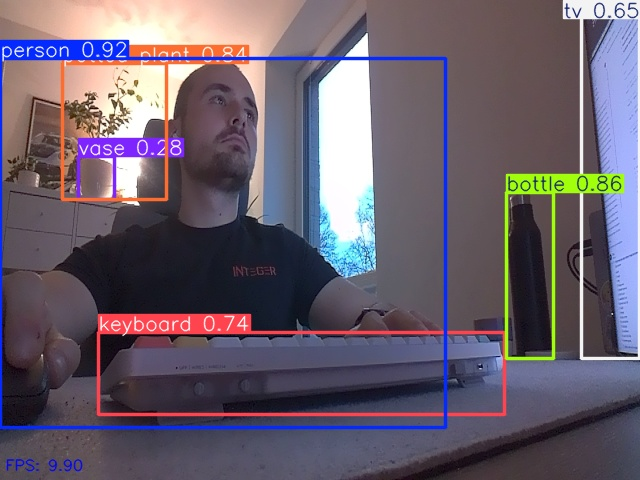

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [ ]:
model = YOLO("models/yolo11x.pt")
run_model(model)

## YOLO Image Segmentation

Image segmentation goes beyond simple object detection by providing pixel-level masks for each detected object. This allows for a more detailed understanding of the scene, as each pixel is classified as belonging to a specific object or the background.

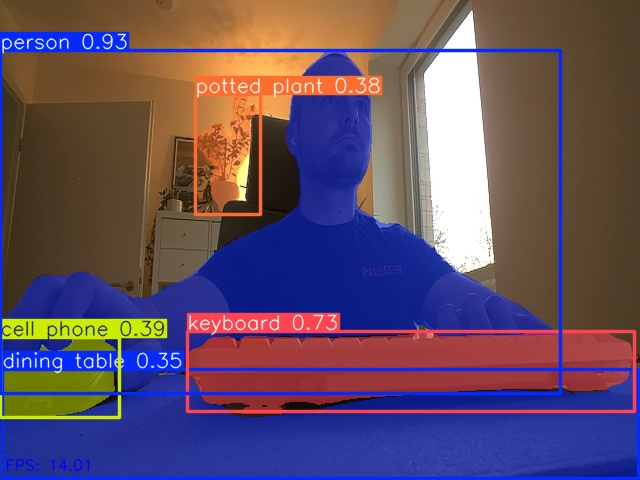

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [ ]:
model = YOLO("models/yolo11m-seg.pt")
run_model(model)

## YOLO Classification

Classification is used to categorize entire images into predefined classes. The model assigns a label to the whole image based on its content. The model outputs a single class label along with a confidence score indicating the certainty of the classification.

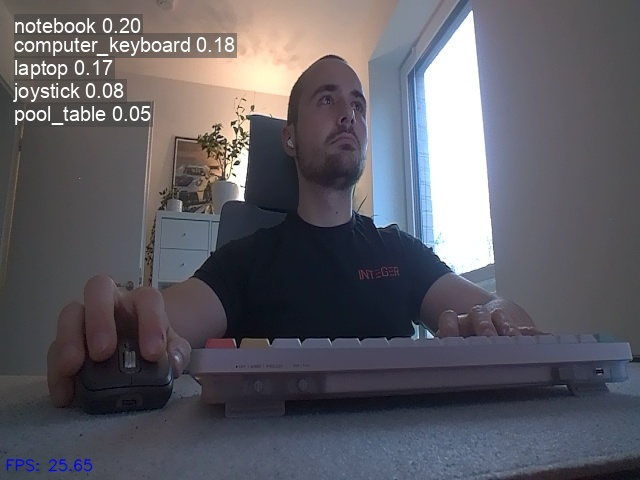

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [ ]:
model = YOLO("models/yolo11m-cls.pt")
run_model(model)

## YOLO Pose Estimation

Pose estimation tries to identify specific features (keypoints) within an image. These keypoints are then represented as coordinates.

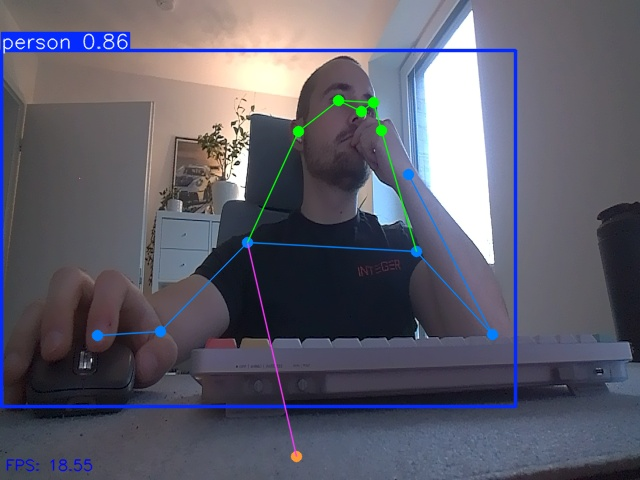

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [ ]:
model = YOLO("models/yolo11s-pose.pt")
run_model(model)

## YOLO Oriented Bounding Box (OBB) Object Detection

Oriented bounding box (OBB) object detection expands on basic object detection by including the angle of an object. For example, it could identify the direction in which a car is moving.

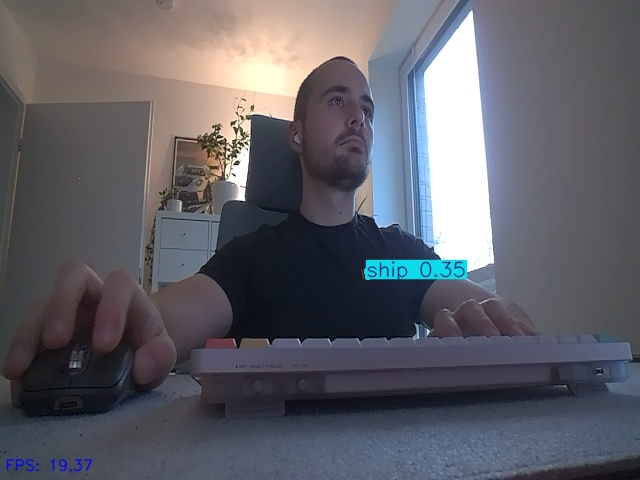

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [ ]:
model = YOLO("models/yolo11n-obb.pt")
run_model(model)